In [13]:
pip install numpy==1.23.5

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 73.5 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scikit-image 0.25.2 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
xarray 2025.1.2 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.23.5 which is incompatible.
albucore 0.0.23 requires numpy>=1.24.4, but you have numpy 1.23.5 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.23.5 which is incompatible.
blosc2 3.3.0 requires numpy>=1.26, but you have numpy 1.23.5 which is incompatible.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.23

In [1]:
pip install gym

In [2]:
!apt-get install -y swig cmake libgl1-mesa-glx libosmesa6-dev libglfw3

!pip install box2d-py==2.3.5 pygame==2.1.3 gym==0.25.2

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libglfw3 is already the newest version (3.3.6-1).
swig is already the newest version (4.0.2-1ubuntu1).
cmake is already the newest version (3.22.1-1ubuntu1.22.04.2).
libosmesa6-dev is already the newest version (23.2.1-1ubuntu3.1~22.04.3).
libgl1-mesa-glx is already the newest version (23.0.4-0ubuntu1~22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


In [3]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.multiprocessing as mp
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import h5py

# **A2C Algorithm Implementation**

In [4]:
learning_rate = 3e-4
gamma = 0.99
entropy_beta = 0.01
num_threads = 2
max_episodes = 3000
update_interval = 5

In [5]:
class ActorCritic(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(ActorCritic, self).__init__()
        self.shared = nn.Sequential(
            nn.Linear(input_dim, 256), nn.ReLU(),
            nn.Linear(256, 128), nn.ReLU()
        )
        self.actor = nn.Linear(128, output_dim)
        self.critic = nn.Linear(128, 1)

    def forward(self, x):
        x = self.shared(x)
        return self.actor(x), self.critic(x)

In [6]:
def actor_learner(global_model, optimizer, thread_id, global_episode, reward_queue):
    env = gym.make("BipedalWalker-v3")
    local_model = ActorCritic(env.observation_space.shape[0], env.action_space.shape[0])
    local_model.load_state_dict(global_model.state_dict())

    while global_episode.value < max_episodes:
        state = env.reset()[0] if isinstance(env.reset(), tuple) else env.reset()
        log_probs, values, rewards, entropies = [], [], [], []
        done = False
        ep_reward = 0

        for _ in range(update_interval):
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
            logits, value = local_model(state_tensor)
            dist = torch.distributions.Normal(logits, torch.ones_like(logits) * 0.1)
            action = dist.sample()
            log_prob = dist.log_prob(action).sum(dim=-1)
            entropy = dist.entropy().sum(dim=-1)
            next_state, reward, done, _ = env.step(action.clamp(-1.0, 1.0).squeeze().detach().numpy())

            log_probs.append(log_prob)
            values.append(value.squeeze())
            rewards.append(reward)
            entropies.append(entropy)
            ep_reward += reward
            state = next_state

            if done:
                break

        R = 0 if done else local_model(torch.tensor(state, dtype=torch.float32).unsqueeze(0))[1].item()
        returns = []
        for r in reversed(rewards):
            R = r + gamma * R
            returns.insert(0, R)

        returns = torch.tensor(returns)
        values = torch.stack(values)
        log_probs = torch.stack(log_probs)
        entropies = torch.stack(entropies)
        advantage = returns - values.detach()

        actor_loss = -(log_probs * advantage).mean() - entropy_beta * entropies.mean()
        critic_loss = (returns - values).pow(2).mean()
        total_loss = actor_loss + critic_loss

        optimizer.zero_grad()
        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(local_model.parameters(), max_norm=0.5)
        for global_param, local_param in zip(global_model.parameters(), local_model.parameters()):
            global_param._grad = local_param.grad
        optimizer.step()
        local_model.load_state_dict(global_model.state_dict())

        with global_episode.get_lock():
            global_episode.value += 1
        reward_queue.put((thread_id, global_episode.value, ep_reward))

In [7]:
def train():
    env = gym.make("BipedalWalker-v3")
    global_model = ActorCritic(env.observation_space.shape[0], env.action_space.shape[0])
    global_model.share_memory()
    optimizer = optim.Adam(global_model.parameters(), lr=learning_rate)
    global_episode = mp.Value('i', 0)
    reward_queue = mp.Queue()

    processes = []
    for i in range(num_threads):
        p = mp.Process(target=actor_learner, args=(global_model, optimizer, i, global_episode, reward_queue))
        p.start()
        processes.append(p)

    rewards = []
    while True:
        try:
            thread_id, ep_num, reward = reward_queue.get(timeout=2)
            rewards.append((ep_num, reward))
            print(f"[Thread {thread_id}] Episode {ep_num} | Reward: {reward:.2f}")
            if ep_num >= max_episodes:
                break
        except:
            break

    for p in processes:
        p.join()
    return global_model, rewards

In [8]:
def plot_rewards(rewards):
    episodes, reward_vals = zip(*rewards)
    plt.plot(episodes, reward_vals)
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.title("Training Rewards: A2C on BipedalWalker-v3")
    plt.grid()
    plt.show()

    smoothed_rewards = pd.Series(reward_vals).rolling(window=50).mean()
    plt.plot(episodes, smoothed_rewards)
    plt.xlabel("Episode")
    plt.ylabel("Smoothed Reward")
    plt.title("Smoothed Rewards: A2C on BipedalWalker-v3")
    plt.grid()
    plt.show()

In [9]:
def evaluate(model, episodes=10):
    env = gym.make("BipedalWalker-v3")
    total_rewards = []
    for episode in range(episodes):
        state = env.reset()[0] if isinstance(env.reset(), tuple) else env.reset()
        done = False
        ep_reward = 0
        while not done:
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            logits, _ = model(state_tensor)
            action = logits.squeeze().detach().numpy()
            step_result = env.step(action.clip(-1.0, 1.0))
            if len(step_result) == 5:
                state, reward, terminated, truncated, _ = step_result
                done = terminated or truncated
            else:
                state, reward, done, _ = step_result
            ep_reward += reward
        total_rewards.append(ep_reward)
        print(f"[EVAL] Episode {episode+1}: {ep_reward:.2f}")
    env.close()

    plt.plot(range(1, 11), total_rewards)
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.title("Greedy Evaluation Rewards")
    plt.grid()
    plt.show()

# **Training and Evaluation**

In [10]:
model, rewards = train()

/usr/local/lib/python3.11/dist-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/usr/local/lib/python3.11/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/local/lib/python3.11/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.cloud')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-pa

[Thread 1] Episode 1 | Reward: -0.15
[Thread 0] Episode 2 | Reward: -0.15
[Thread 1] Episode 3 | Reward: -0.15
[Thread 1] Episode 4 | Reward: -0.54
[Thread 0] Episode 5 | Reward: -0.15
[Thread 1] Episode 6 | Reward: -0.43
[Thread 0] Episode 7 | Reward: -0.54
[Thread 1] Episode 8 | Reward: -0.60
[Thread 0] Episode 9 | Reward: -0.47
[Thread 1] Episode 10 | Reward: -0.48
[Thread 0] Episode 11 | Reward: -0.62
[Thread 1] Episode 12 | Reward: -0.52
[Thread 0] Episode 13 | Reward: -0.48
[Thread 1] Episode 14 | Reward: -0.49
[Thread 0] Episode 15 | Reward: -0.52
[Thread 1] Episode 16 | Reward: -0.46
[Thread 0] Episode 17 | Reward: -0.48
[Thread 1] Episode 18 | Reward: -0.58
[Thread 0] Episode 19 | Reward: -0.47
[Thread 1] Episode 20 | Reward: -0.55
[Thread 0] Episode 21 | Reward: -0.55
[Thread 1] Episode 22 | Reward: -0.51
[Thread 0] Episode 23 | Reward: -0.55
[Thread 1] Episode 24 | Reward: -0.54
[Thread 0] Episode 25 | Reward: -0.51
[Thread 1] Episode 26 | Reward: -0.51
[Thread 0] Episode 27

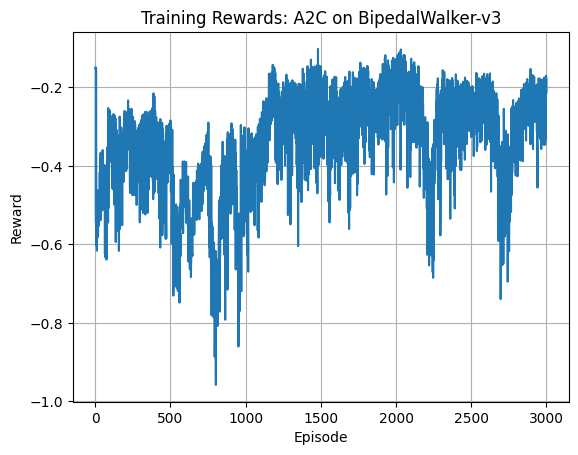

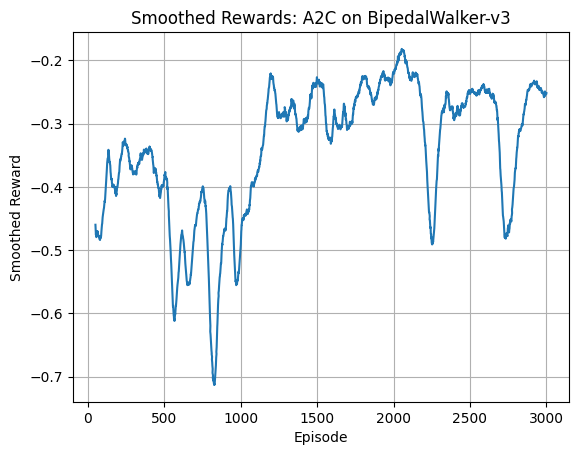

In [11]:
plot_rewards(rewards)

/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


[EVAL] Episode 1: -98.24
[EVAL] Episode 2: -97.64
[EVAL] Episode 3: -97.65
[EVAL] Episode 4: -97.63
[EVAL] Episode 5: -97.67
[EVAL] Episode 6: -97.63
[EVAL] Episode 7: -97.63
[EVAL] Episode 8: -97.67
[EVAL] Episode 9: -97.66
[EVAL] Episode 10: -97.63


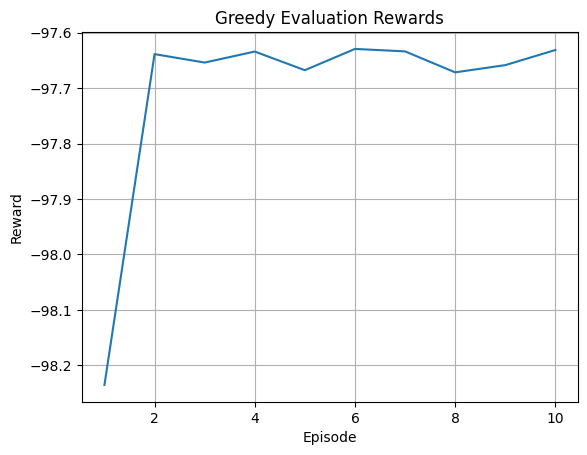

In [12]:
evaluate(model)

In [13]:
save_path = "a3_part_2_a2c_BipedalWalker-v3_lalasamy_kanishar.h5"
def save_model(model, path):
    with h5py.File(path, 'w') as hf:
        for name, param in model.named_parameters():
            hf.create_dataset(name, data=param.detach().cpu().numpy())

save_model(model, save_path)

In [14]:
from google.colab import files
files.download("a3_part_2_a2c_BipedalWalker-v3_lalasamy_kanishar.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>